In [1]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import select
import time
import re
import os
import glob

def start_server(error_rate, num_pages, fanout, level_policy, port):
    cmd = f"./bin/server -e {error_rate} -n {num_pages} -f {fanout} -l {level_policy} -p {port}"
    server_process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return server_process

def stop_server(server_process):
    server_process.terminate()
    #time.sleep(1)  # Wait 1 second to ensure the server has stopped

def delete_lsm_files():
    lsm_files = glob.glob('/tmp/lsm-*')
    for file in lsm_files:
        try:
            os.remove(file)
        except OSError:
            print(f"Error: Unable to delete file: {file}")

In [2]:
def wait_for_server_ready(server_process):
    start_time = time.time()
    timeout = 60  # Timeout in seconds

    while True:
        ready, _, _ = select.select([server_process.stdout], [], [], timeout)
        if ready:
            output_line = server_process.stdout.readline().decode()
            print(output_line, end="")
            if "New client connected" in output_line:
                break
        elif time.time() - start_time > timeout:
            raise TimeoutError("Server did not print 'New client connected' within the timeout period.")

def run_experiment(port, workload_path):
    client_cmd = f'./bin/client -p {port}'
    
    # Start the client process
    client_process = subprocess.Popen(client_cmd.split(), stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
    # Wait for the server to print "New client connected"
    try:
        wait_for_server_ready(server_process)
    except TimeoutError as e:
        print(e)
        client_process.terminate()
        return None

    # Run the benchmark command
    benchmark_cmd = f'b {workload_path}\n'
    client_process.stdin.write(benchmark_cmd.encode())
    client_process.stdin.flush()

    time_taken = None
    while True:
        # Wait for output from the server process
        ready, _, _ = select.select([server_process.stdout], [], [], 60)  # timeout
        if ready:
            output_line = server_process.stdout.readline().decode()
            print(output_line, end="")
            match = re.search(r'(\d+) microseconds', output_line)
            if match:
                time_taken = int(match.group(1))
                break

    client_process.terminate()
    return time_taken


In [3]:
params = {
    'error_rate': [0.01, 0.05],
    'num_pages': [256, 512, 1024],
    'fanout': [2, 5, 10],
    'level_policy': ['LAZY_LEVELED', 'LEVELED', 'TIERED'],
    'port': 1249
}

results = []

delete_lsm_files()

for count, (error_rate, num_pages, fanout, level_policy) in enumerate(itertools.product(params['error_rate'], params['num_pages'], params['fanout'], params['level_policy'])):
    server_process = start_server(error_rate, num_pages, fanout, level_policy, params['port'] + count)
    time_taken = run_experiment(params['port'] + count, 'workload.txt')
    stop_server(server_process)

    result = {
        'error_rate': error_rate,
        'num_pages': num_pages,
        'fanout': fanout,
        'level_policy': level_policy,
        'time_taken': time_taken
    }
    results.append(result)

results_df = pd.DataFrame(results)



Server started, listening on port 1249
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 524288
  LSM-tree fanout: 2
  Level policy: LAZY_LEVELED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 183356 microseconds (0 minutes, 0.18 seconds)

Server started, listening on port 1250
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 524288
  LSM-tree fanout: 2
  Level policy: LEVELED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 178789 microseconds (0 minutes, 0.18 seconds)

Server started, listening on port 1251
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 524288
  LSM-tree fanout: 2
  Level policy: TIERED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt

Benchmark: Workload workload.txt file took 199498 microseconds (0 minutes, 0.20 seconds)

Server started, listening on port 1273
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 2097152
  LSM-tree fanout: 10
  Level policy: LAZY_LEVELED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 194649 microseconds (0 minutes, 0.19 seconds)

Server started, listening on port 1274
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 2097152
  LSM-tree fanout: 10
  Level policy: LEVELED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 176805 microseconds (0 minutes, 0.18 seconds)

Server started, listening on port 1275
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 2097152
  LSM-tree fanout: 10
  Level policy: TIERED

LSM Tree ready and waiting f

Benchmark: Workload workload.txt file took 152291 microseconds (0 minutes, 0.15 seconds)

Server started, listening on port 1297
LSMTree parameters:
  Bloom filter error rate: 0.05
  Number of buffer pages: 2097152
  LSM-tree fanout: 5
  Level policy: LAZY_LEVELED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 148272 microseconds (0 minutes, 0.15 seconds)

Server started, listening on port 1298
LSMTree parameters:
  Bloom filter error rate: 0.05
  Number of buffer pages: 2097152
  LSM-tree fanout: 5
  Level policy: LEVELED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 148317 microseconds (0 minutes, 0.15 seconds)

Server started, listening on port 1299
LSMTree parameters:
  Bloom filter error rate: 0.05
  Number of buffer pages: 2097152
  LSM-tree fanout: 5
  Level policy: TIERED

LSM Tree ready and waiting for 

In [4]:
results_df

,error_rate,num_pages,fanout,level_policy,time_taken
0,0.01,256,2,LAZY_LEVELED,183356
1,0.01,256,2,LEVELED,178789
2,0.01,256,2,TIERED,214025
3,0.01,256,5,LAZY_LEVELED,190652
4,0.01,256,5,LEVELED,204391
5,0.01,256,5,TIERED,180708
6,0.01,256,10,LAZY_LEVELED,188460
7,0.01,256,10,LEVELED,167104
8,0.01,256,10,TIERED,186591
9,0.01,512,2,LAZY_LEVELED,205297


In [5]:
for error_rate in params['error_rate']:
    for level_policy in params['level_policy']:
        # Filter the data for the current error rate and level policy combination
        data = results_df[(results_df['error_rate'] == error_rate) & (results_df['level_policy'] == level_policy)]


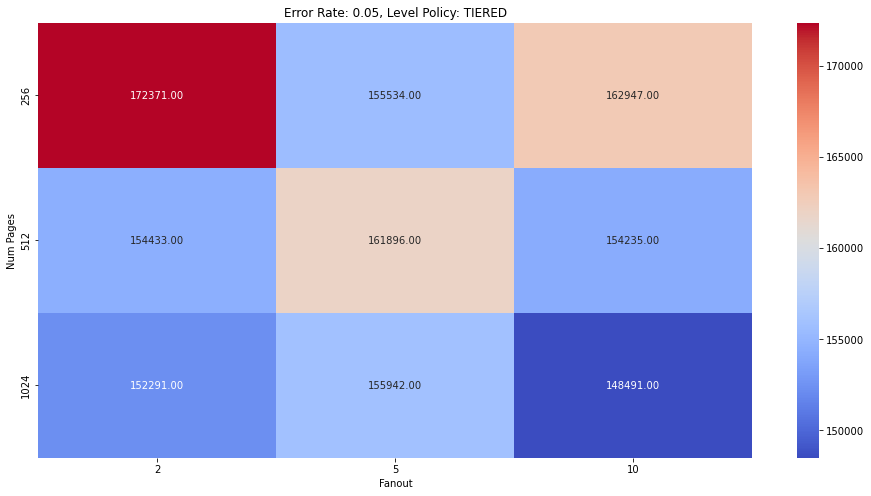

In [6]:
# Create a heatmap of time taken with varying num_pages and fanout values
pivot_table = data.pivot_table(values='time_taken', index='num_pages', columns='fanout')
plt.figure(figsize=(16, 8))

ax = sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='coolwarm')

# Set plot title and labels
ax.set_title(f'Error Rate: {error_rate}, Level Policy: {level_policy}')
ax.set_xlabel('Fanout')
ax.set_ylabel('Num Pages')

# Show the plot
plt.show()


In [7]:
params = {
    'error_rate': [0.01],
    'num_pages': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
    'fanout': [10],
    'level_policy': ['LAZY_LEVELED', 'LEVELED', 'TIERED'],
    'port': 1234
}

results = []

delete_lsm_files()

for count, (error_rate, num_pages, fanout, level_policy) in enumerate(itertools.product(params['error_rate'], params['num_pages'], params['fanout'], params['level_policy'])):
    server_process = start_server(error_rate, num_pages, fanout, level_policy, params['port'] + count)
    time_taken = run_experiment(params['port'] + count, 'workload.txt')
    stop_server(server_process)

    result = {
        'error_rate': error_rate,
        'num_pages': num_pages,
        'fanout': fanout,
        'level_policy': level_policy,
        'time_taken': time_taken
    }
    results.append(result)

results_df = pd.DataFrame(results)



Server started, listening on port 1234
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 2048
  LSM-tree fanout: 10
  Level policy: LAZY_LEVELED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 4569376 microseconds (0 minutes, 4.57 seconds)

Server started, listening on port 1235
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 2048
  LSM-tree fanout: 10
  Level policy: LEVELED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 5058559 microseconds (0 minutes, 5.06 seconds)

Server started, listening on port 1236
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 2048
  LSM-tree fanout: 10
  Level policy: TIERED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt 

Benchmark: Workload workload.txt file took 159444 microseconds (0 minutes, 0.16 seconds)

Server started, listening on port 1259
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 524288
  LSM-tree fanout: 10
  Level policy: LEVELED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 163503 microseconds (0 minutes, 0.16 seconds)

Server started, listening on port 1260
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 524288
  LSM-tree fanout: 10
  Level policy: TIERED

LSM Tree ready and waiting for input
New client connected
Benchmark: loaded "workload.txt"
Benchmark: Workload workload.txt file took 156214 microseconds (0 minutes, 0.16 seconds)

Server started, listening on port 1261
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 1048576
  LSM-tree fanout: 10
  Level policy: LAZY_LEVELED

LSM Tree ready and waiting for

In [8]:
results_df

,error_rate,num_pages,fanout,level_policy,time_taken
0,0.01,1,10,LAZY_LEVELED,4569376
1,0.01,1,10,LEVELED,5058559
2,0.01,1,10,TIERED,2185026
3,0.01,2,10,LAZY_LEVELED,3842971
4,0.01,2,10,LEVELED,3852643
5,0.01,2,10,TIERED,2577366
6,0.01,4,10,LAZY_LEVELED,2231557
7,0.01,4,10,LEVELED,2239704
8,0.01,4,10,TIERED,1688660
9,0.01,8,10,LAZY_LEVELED,505920


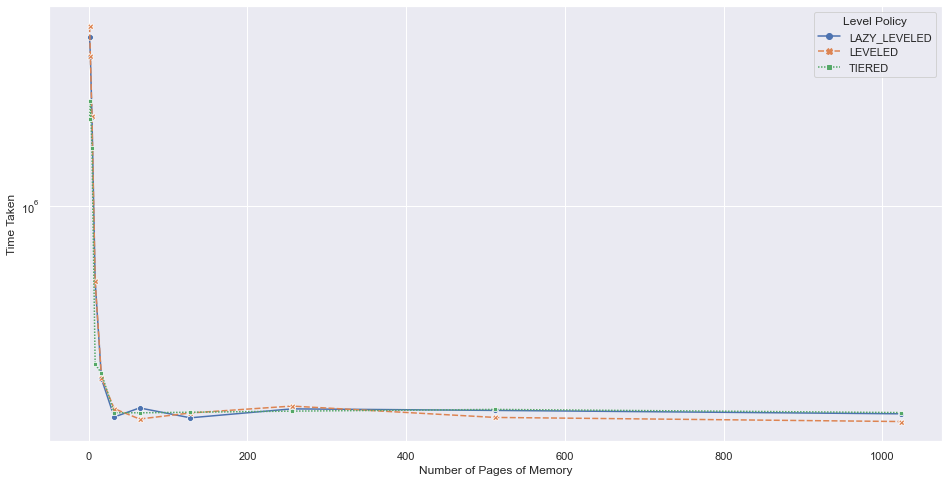

In [9]:
# This plot is too dominated by the page sizes less than 32
sns.set(style="darkgrid")
plt.figure(figsize=(16, 8))

line_plot = sns.lineplot(data=results_df, x="num_pages", y="time_taken", hue="level_policy", style="level_policy", markers=True)

plt.xlabel("Number of Pages of Memory")
plt.ylabel("Time Taken")
plt.legend(title="Level Policy")
plt.yscale("log")  # Set y-axis to logarithmic scale - barely does anything
plt.show()

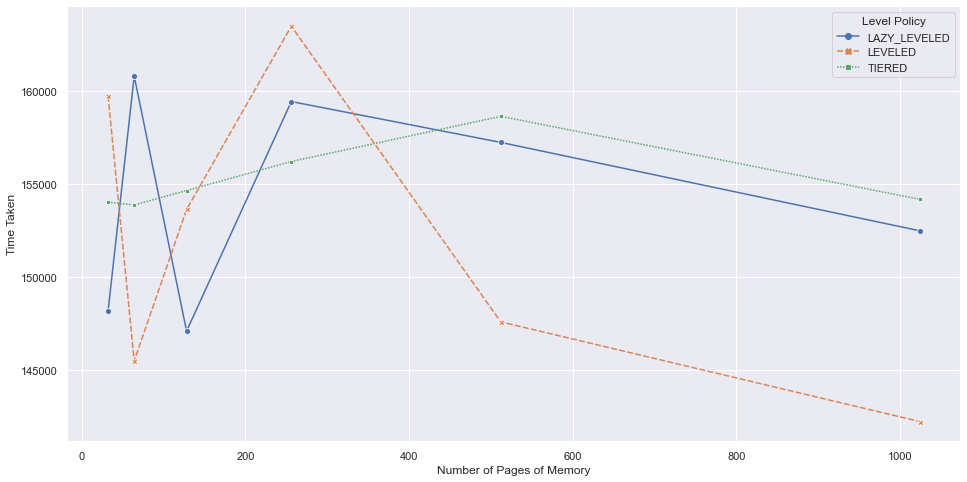

In [10]:
# Filter the DataFrame to keep only rows where num_pages >= 32 (32 * 512 bytes per page so 16K buffer)
filtered_results_df = results_df[results_df['num_pages'] >= 32]

sns.set(style="darkgrid")
plt.figure(figsize=(16, 8))

line_plot = sns.lineplot(data=filtered_results_df, x="num_pages", y="time_taken", hue="level_policy", style="level_policy", markers=True)

plt.xlabel("Number of Pages of Memory")
plt.ylabel("Time Taken")
plt.legend(title="Level Policy")
plt.show()